# Fine Granularity Analysis - Fine Granularity Human Sentiments of Heat Exposure

Author: Fangzheng Lyu

This notebook is related to the paper [Mapping dynamic human sentiments of heat exposure with location-based social media data](https://www.tandfonline.com/doi/full/10.1080/13658816.2024.2343063)

Evaulting Twitter-based heat exposure dynamics can be analyzed at a finer temporal resolution. In this study, we further looked at how the heat exposure changes on September 26th, 2021. On September 26rh, there is a significant temperate rises in Chicago where the highest temperature increased from 70 degrees Fahrenheit to 84 degrees Fahrenheit from September 25th, 2021, to September 26th, 2021. We investigated the dynamics of heat exposure at a fine temporal resolution to gain insight into the changes in people’s exposure to dramatic temperature rises within a day.

## Notebook Outline
- [Read Twitter Data and Data Processing](#read)
- [Understand the Human Sentiments of Heat Exposure of Twitter Data](#understand)
- [Distribute All the Social Media Data into the 3-hour Temporal Bins](#Distribute)
- [Visualization](#Visualization)

Import necessary libraries

In [1]:
import pytz
from datetime import datetime, timedelta
import os
import geopandas as gpd
import json
from shapely.geometry import Polygon, Point, MultiPolygon
import shapefile
import re
import shapefile as shp  # Requires the pyshp package
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.colors as mcolors
import numpy as np
import random
random.seed(10)

<a id='read'></a>

## 1. Read Twitter Data and data processing

Read the shapefile of Chicago.

In [2]:
shapefile = gpd.read_file("./geo/geo_export_5bb8636f-65b7-450a-8fd9-7f01027fd84b.shp")
chicago_shape = shapefile["geometry"][0]

Retrieve the information of all the Twitter file available

In [3]:
os.listdir('./data/')

['250000-tweets-2021-09-25_04-59-49.json',
 '250000-tweets-2021-09-26_01-46-49.json',
 '250000-tweets-2021-09-25_20-12-57.json',
 '250000-tweets-2021-09-26_19-43-23.json',
 '250000-tweets-2021-09-26_22-13-26.json',
 '250000-tweets-2021-09-25_17-48-51.json',
 '250000-tweets-2021-09-26_09-39-36.json',
 '250000-tweets-2021-09-26_07-36-30.json',
 '250000-tweets-2021-09-25_22-39-35.json',
 '250000-tweets-2021-09-25_13-24-18.json',
 '250000-tweets-2021-09-25_01-48-23.json',
 '250000-tweets-2021-09-26_11-29-11.json',
 '250000-tweets-2021-09-26_13-18-44.json',
 '250000-tweets-2021-09-25_09-29-48.json',
 '250000-tweets-2021-09-26_17-16-06.json',
 '250000-tweets-2021-09-26_15-10-52.json',
 '250000-tweets-2021-09-25_11-25-23.json',
 '250000-tweets-2021-09-25_07-33-30.json',
 '250000-tweets-2021-09-25_15-34-24.json',
 '250000-tweets-2021-09-26_04-56-08.json']

Find all the geo-tagged Twitter data in the city of Chicago.

In [4]:
## get the twitter in chicago
## City scale analysis
## This block of code will takes a long time
## We iterate through all the twitter collected for find twitter in chicago
## Get the filename
filelist = os.listdir('./data/')
filelist

twitter_in_chicago = []

# Opening JSON file
for filename in filelist:
    filepath = "./data/"+filename
    print(filepath)
    f = open(filepath)
    data = json.load(f)
    
    ## Read the data if the centroid of the twitter point polygon lies within the boundary of the city of Chicago
    for i in range(0, len(data)):
        try:
            ##Need to deal with case when the shapefile is too big
            text = data[i]["text"]
            t = data[i]['created_at']
            ## Case 1
            ## Twitter with exact geospatial location
            if (data[i]['geo']!=None):
                lat = data[i]['geo']['coordinates'][0]
                lon = data[i]['geo']['coordinates'][1]
                exact_loc = Point(lon, lat)
                if chicago_shape.contains(point):
                    ## print("inside")
                    twitter_in_chicago.append((exact_loc, t, text))
            else:
                ## Twitter with a polygon bounding box
                poly = data[i]['place']['bounding_box']["coordinates"][0]
                lon = -1000
                lat = -1000

                lon = [p[0] for p in poly]
                lat = [p[1] for p in poly]
                centroid = (sum(lon) / len(poly), sum(lat) / len(poly))
                point = Point(centroid)
                ## check if a centroid is in the bounding box of chicago
                if chicago_shape.contains(point):
                    ## print("inside")
                    twitter_in_chicago.append((poly, t, text))
        except:
            ## no geographical location
            pass
    # Closing file
    f.close()

./data/250000-tweets-2021-09-25_04-59-49.json
./data/250000-tweets-2021-09-26_01-46-49.json
./data/250000-tweets-2021-09-25_20-12-57.json
./data/250000-tweets-2021-09-26_19-43-23.json
./data/250000-tweets-2021-09-26_22-13-26.json
./data/250000-tweets-2021-09-25_17-48-51.json
./data/250000-tweets-2021-09-26_09-39-36.json
./data/250000-tweets-2021-09-26_07-36-30.json
./data/250000-tweets-2021-09-25_22-39-35.json
./data/250000-tweets-2021-09-25_13-24-18.json
./data/250000-tweets-2021-09-25_01-48-23.json
./data/250000-tweets-2021-09-26_11-29-11.json
./data/250000-tweets-2021-09-26_13-18-44.json
./data/250000-tweets-2021-09-25_09-29-48.json
./data/250000-tweets-2021-09-26_17-16-06.json
./data/250000-tweets-2021-09-26_15-10-52.json
./data/250000-tweets-2021-09-25_11-25-23.json
./data/250000-tweets-2021-09-25_07-33-30.json
./data/250000-tweets-2021-09-25_15-34-24.json
./data/250000-tweets-2021-09-26_04-56-08.json


In [5]:
print ("There are in total "+str(len(twitter_in_chicago))+" geo-tagged Twitter Collected in Chicago")

There are in total 22717 geo-tagged Twitter Collected in Chicago


<a id='understand'></a>

## 2. Understand the human sentiments of heat exposure of Twitter data

Read the heat dictionary of social media data.

In [6]:
## Read the word heat dictionary
f = open('./geo/data20000.txt','r')
content = f.read()
f.close()
dict_word = {}
content_list = content.split(",")
for i in range(0,len(content_list)):
    try:
        word = content_list[i].split(":")[0].split("'")[1]
        #print(content_list[i].split(":"))
        val = float(content_list[i].split(":")[1])
        dict_word[word] = val
    except:
        pass

Find all the weather-realted Twitter data in the city of Chicago from all the Twitter data in Chicago using the heat dictionary.

In [7]:
## Iterate through all twitter data in chicago

d_twitter = []
for i in range(0, len(twitter_in_chicago)):
    loc = twitter_in_chicago[i][0]
    t = twitter_in_chicago[i][1]
    text = twitter_in_chicago[i][2]
    res = re.findall(r'\w+', text.lower())
    val = 0
    for word in res:
        if word in dict_word.keys():
            val = val + dict_word[word]
    ## remove weather-irrelevant twitter
    ## if none of the word in the heat dictionary show up 
    if (val!=0):
        d_twitter.append((loc, t, val))

In [8]:
print("There are "+str(len(d_twitter))+" weather-related Twitter in Chicago")

There are 857 weather-related Twitter in Chicago


In [9]:
m_dic = {}
m_dic['Jan'] = 1
m_dic['Feb'] = 2
m_dic['Mar'] = 3
m_dic['Apr'] = 4
m_dic['May'] = 5
m_dic['Jun'] = 6
m_dic['Jul'] = 7
m_dic['Aug'] = 8
m_dic['Sep'] = 9
m_dic['Oct'] = 10
m_dic['Nov'] = 11
m_dic['Dec'] = 12

Set up the current datetime, the Central Time in the city of Chicago in the Summer is GMT-5.

In [10]:
curr = datetime(2021,9, 26, 5)

Find the time difference between the current time and the time when the Twitter was posted to conduct fine graunlarity analysis of human sentiments of heat exposure. And find all the weather-related Twitter related data that is collected within the 24 hour timeframe.

In [11]:
## Find the time difference between the current time and the Twitter post time
weather_related_twitter = []
for twitter in d_twitter:
    loc = twitter[0]
    t = twitter[1].split()
    val = twitter[2]
    month = m_dic[t[1]]
    day = int(t[2])
    year = int(t[5])
    hour = int(t[3].split(":")[0])
    minute = int(t[3].split(":")[1])
    twitter_t = datetime(year, month, day, hour, minute)
    diff_hour = (twitter_t - curr).total_seconds() / (60.0*60)
    if (diff_hour<0 or diff_hour>24):
        #print(diff_hour)
        pass
    else:
        weather_related_twitter.append((loc, diff_hour, val))

In [12]:
len(weather_related_twitter)

420

Find the maximum, minimun when the Twitter data is collected and also the number of Twitter getting collected within the 24-hour timeframe.

In [13]:
t = []
for ele in weather_related_twitter:
    t.append(ele[1])
min(t),max(t),len(t)

(0.05, 22.183333333333334, 420)

<a id='Distribute'></a>

## 3. Distribute All the Social Media Data into the 3-hour Temporal Bins

Put all the Twitter collected in the 24-hour timeframe into 3-hour temporal bins. There are 8 different seperate timeslice and each one is of 3 hours. The 8 bins correspond to the timeframe at 0-3, 3-6, 6-9. 9-12. 12-15, 15-18, 18-21, 21-24.

In [14]:
s1 = []
s2 = []
s3 = []
s4 = []
s5 = []
s6 = []
s7 = []
s8 = []
for ele in weather_related_twitter:
    t = ele[1]
    if (t>0 and t<=3):
        s1.append(ele)
    elif (t>3 and t<=6):
        s2.append(ele)
    elif (t>6 and t<=9):
        s3.append(ele)
    elif (t>9 and t<=12):
        s4.append(ele)
    elif (t>12 and t<=15):
        s5.append(ele)
    elif (t>15 and t<=18):
        s6.append(ele)
    elif (t>18 and t<=21):
        s7.append(ele)
    elif (t>21 and t<=24):
        s8.append(ele)

Get how many weather-related Twitter posts are falling into each time bins.

In [15]:
len(s1),len(s2),len(s3),len(s4),len(s5),len(s6), len(s7),len(s8)

(22, 9, 23, 67, 88, 74, 95, 42)

<a id='Visualization'></a>

## 4. Visualization

Visualize the fine-temporal-granularity maps for human sentiments of heat exposure.

The analysis in condected at 1km * 1km spatial resoluiton.

In [16]:
## Generate raster based about 1 km spatial resoltuion 
## one Degree latitude = 111 km
## In chicago, where latitude = 41.881832, one Degree longitude = 82 km
## We use this estimation for the following ananlsis
## This work as the city of Chicago is small
lat_start = 41.05
lon_start = -87.96

incre_lat = 1/111
incre_lon = 1/82

lat_end = 42.05
lon_end = -87.5

raster = []

lat = lat_start

while(lat<lat_end):
    lon = lon_start
    while(lon<lon_end):
        curr_point = Point(lon, lat)
        if (curr_point.within(chicago_shape)):
            raster.append([lon, lat])
        lon = lon+incre_lon
    lat = lat+incre_lat

Generate reuslt for the human sentiments of heat exposure at different timeframe at fine temporal granularity.

In [17]:
## Generate a random point from a polygon
import random

def generate_random(number, polygon):
    minx, miny, maxx, maxy = polygon.bounds
    pnt = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
    return pnt

In [18]:
## Function to generate random location twitter
## For monte caro experiment
## Enable exact and poly if you want to see how many twitter has exact location and how many comes with a polygon
#exact = 0
#poly = 0
def generate_random_loc(weather_related_twitter):
    random_loc_twitter = []
    for ele in weather_related_twitter:
        loc = ele[0]
        point = 0
        #print(loc)
        if (type(loc)==Point):
            ## exact location extracted
            point = loc
            #exact = exact+1
        else:
            ## Select a random point from a multi-polygon
            point = generate_random(1, Polygon(loc))
            #poly = poly+1
        random_loc_twitter.append([point, ele[2]])
    return random_loc_twitter

Calcualte the human sentiments of heat exposure. Using Inverse Distance Weighting (IDW) for those spatial unit that doesn't have a points. And using Monte-Carlo simulation to take care of those multi-polygon locations in the social media posts.

In [19]:
## for 8 bins
def get_heat_exposure(weather_related_twitter):
    d_final = {}

    for i in range(0, 10):
        ## try 10 random time
        #print("current "+str(i))

        ## Conduct kernel density estimation
        random_loc_twitter = generate_random_loc(weather_related_twitter)

        ### fill with inverse distance weighting


        for ele in raster:
            lon = ele[0]
            lat = ele[1]
            ## iterate through all the values in the existing twitter
            up = 0
            down = 0
            IDW = 0
            for twitter in random_loc_twitter:
                pt = twitter[0]
                curr_x = pt.x
                curr_y = pt.y
                curr_val = twitter[1]

                distx = (curr_x-lon)*82
                disty = (curr_y-lat)*111

                w = 1/np.sqrt(distx*distx+disty*disty)

                down = down+w
                up = up+w*curr_val
            rt = up/down

            key = (ele[0],ele[1])
            if (key not in d_final.keys()):
                d_final[key]=[rt]
            else:
                d_final[key].append(rt)
    return d_final

In [20]:
s1_rt = get_heat_exposure(s1)
s2_rt = get_heat_exposure(s2)
s3_rt = get_heat_exposure(s3)
s4_rt = get_heat_exposure(s4)
s5_rt = get_heat_exposure(s5)
s6_rt = get_heat_exposure(s6)
s7_rt = get_heat_exposure(s7)
s8_rt = get_heat_exposure(s8)

Get the heat exposure.

In [21]:
heat_exposure_map_1 = {}
for key in s1_rt.keys():
    ## Get the average hot exposure
    heat_exposure_map_1[key] = np.mean(s1_rt[key])
    
heat_exposure_map_2 = {}
for key in s2_rt.keys():
    ## Get the average hot exposure
    heat_exposure_map_2[key] = np.mean(s2_rt[key])
    
heat_exposure_map_3 = {}
for key in s3_rt.keys():
    ## Get the average hot exposure
    heat_exposure_map_3[key] = np.mean(s3_rt[key])
    
heat_exposure_map_4 = {}
for key in s4_rt.keys():
    ## Get the average hot exposure
    heat_exposure_map_4[key] = np.mean(s4_rt[key])
    
heat_exposure_map_5 = {}
for key in s5_rt.keys():
    ## Get the average hot exposure
    heat_exposure_map_5[key] = np.mean(s5_rt[key])
    
heat_exposure_map_6 = {}
for key in s6_rt.keys():
    ## Get the average hot exposure
    heat_exposure_map_6[key] = np.mean(s6_rt[key])
    
heat_exposure_map_7 = {}
for key in s7_rt.keys():
    ## Get the average hot exposure
    heat_exposure_map_7[key] = np.mean(s7_rt[key])
    
heat_exposure_map_8 = {}
for key in s8_rt.keys():
    ## Get the average hot exposure
    heat_exposure_map_8[key] = np.mean(s8_rt[key])

Get the maximum and minimum to normalize the human sentiments of heat exposure.

In [22]:
mn = min(min(heat_exposure_map_1.values()),min(heat_exposure_map_2.values()),min(heat_exposure_map_3.values()),min(heat_exposure_map_4.values()),min(heat_exposure_map_5.values()),min(heat_exposure_map_6.values()), min(heat_exposure_map_7.values()),min(heat_exposure_map_8.values()))
mx = max(max(heat_exposure_map_1.values()),max(heat_exposure_map_2.values()),max(heat_exposure_map_3.values()),max(heat_exposure_map_4.values()),max(heat_exposure_map_5.values()),max(heat_exposure_map_6.values()), max(heat_exposure_map_7.values()),max(heat_exposure_map_8.values()))

In [23]:
mn, mx

(-0.2518099773585837, 0.09851675003996149)

Calcualte the normalized human sentiments of heat exposure.

In [24]:
for key in heat_exposure_map_1.keys():
    norm = (heat_exposure_map_1[key]-mn)/(mx-mn)
    heat_exposure_map_1[key] = norm

In [25]:
for key in heat_exposure_map_2.keys():
    norm = (heat_exposure_map_2[key]-mn)/(mx-mn)
    heat_exposure_map_2[key] = norm

In [26]:
for key in heat_exposure_map_3.keys():
    norm = (heat_exposure_map_3[key]-mn)/(mx-mn)
    heat_exposure_map_3[key] = norm

In [27]:
for key in heat_exposure_map_4.keys():
    norm = (heat_exposure_map_4[key]-mn)/(mx-mn)
    heat_exposure_map_4[key] = norm

In [28]:
for key in heat_exposure_map_5.keys():
    norm = (heat_exposure_map_5[key]-mn)/(mx-mn)
    heat_exposure_map_5[key] = norm

In [29]:
for key in heat_exposure_map_6.keys():
    norm = (heat_exposure_map_6[key]-mn)/(mx-mn)
    heat_exposure_map_6[key] = norm

In [30]:
for key in heat_exposure_map_7.keys():
    norm = (heat_exposure_map_7[key]-mn)/(mx-mn)
    heat_exposure_map_7[key] = norm

In [31]:
for key in heat_exposure_map_8.keys():
    norm = (heat_exposure_map_8[key]-mn)/(mx-mn)
    heat_exposure_map_8[key] = norm

Create dataframe for visualzation.

In [32]:
lonl = []
latl = []
var1 = []
var2 = []
var3 = []
var4 = []
var5 = []
var6 = []
var7 = []
var8 = []

final_heat_exposure_map = {}
for key in heat_exposure_map_1.keys():
    
    lonl.append(key[0])
    latl.append(key[1])
    var1.append(heat_exposure_map_1[key])
    var2.append(heat_exposure_map_2[key])
    var3.append(heat_exposure_map_3[key])
    var4.append(heat_exposure_map_4[key])
    var5.append(heat_exposure_map_5[key])
    var6.append(heat_exposure_map_6[key])
    var7.append(heat_exposure_map_7[key])
    var8.append(heat_exposure_map_8[key])

In [33]:
df = pd.DataFrame(np.column_stack([lonl, latl, var1, var2, var3, var4, var5, var6, var7, var8]), 
                  columns=['lon', 'lat', '0-3', '3-6', '6-9', '9-12', '12-15', '15-18', '18-21', '21-24'])

In [36]:
df

,lon,lat,0-3,3-6,6-9,9-12,12-15,15-18,18-21,21-24
0,-87.545366,41.644595,0.292482,0.869844,0.249160,0.290081,0.336086,0.315248,0.508729,0.139775
1,-87.533171,41.644595,0.282627,0.866669,0.266217,0.291936,0.336143,0.317140,0.488466,0.138265
2,-87.618537,41.653604,0.321806,0.891322,0.247199,0.271287,0.384103,0.280509,0.459762,0.160673
3,-87.606341,41.653604,0.321581,0.887760,0.225174,0.274702,0.386363,0.277310,0.468153,0.163585
4,-87.594146,41.653604,0.324627,0.882756,0.204088,0.267107,0.387400,0.272546,0.482209,0.177834
...,...,...,...,...,...,...,...,...,...,...
588,-87.777073,42.013964,0.420654,0.771314,0.204853,0.288908,0.335838,0.153725,0.414402,0.154198
589,-87.703902,42.013964,0.472375,0.736350,0.268860,0.312718,0.325629,0.224607,0.434550,0.098847
590,-87.691707,42.013964,0.425405,0.717932,0.279370,0.317163,0.321651,0.223713,0.437154,0.136120
591,-87.679512,42.013964,0.411561,0.700534,0.285818,0.320018,0.298759,0.221255,0.428012,0.166890


Visualize result for 6-9.

array([<Axes: xlabel='lon', ylabel='lat'>], dtype=object)

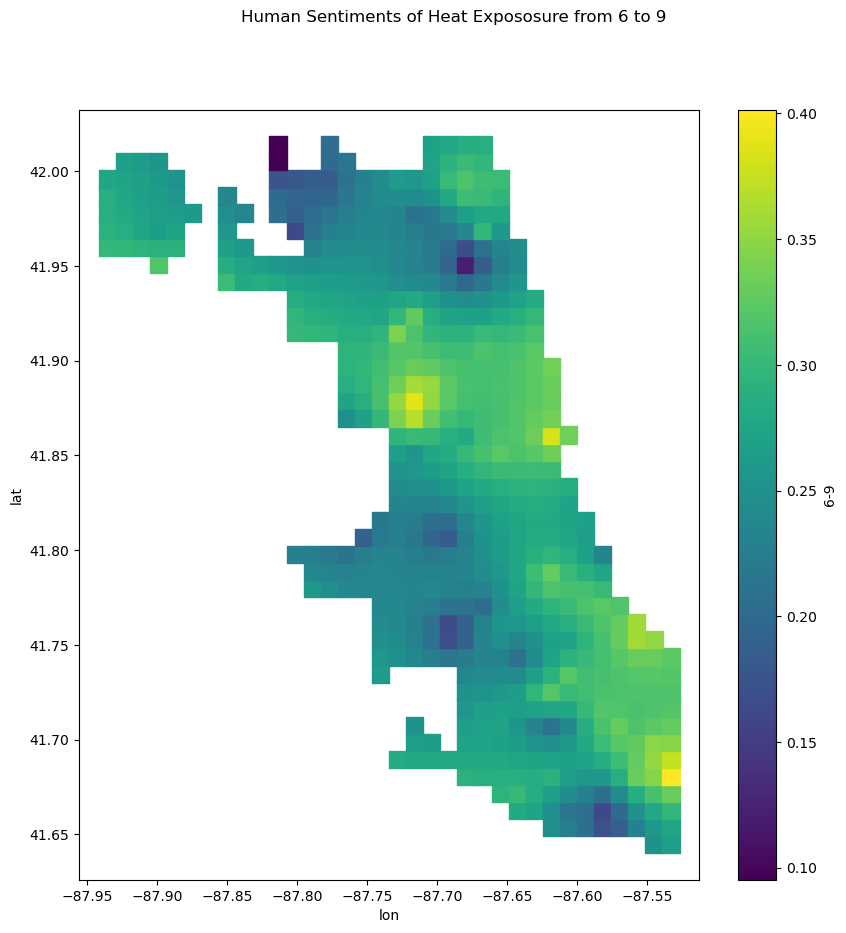

In [39]:
df.plot.scatter(title='Human Sentiments of Heat Expososure from 6 to 9', x='lon', y='lat', c='6-9', figsize = [10,10], subplots=True, marker="s", s = 155, colormap='viridis')

Visualize result for 9-12.

array([<Axes: xlabel='lon', ylabel='lat'>], dtype=object)

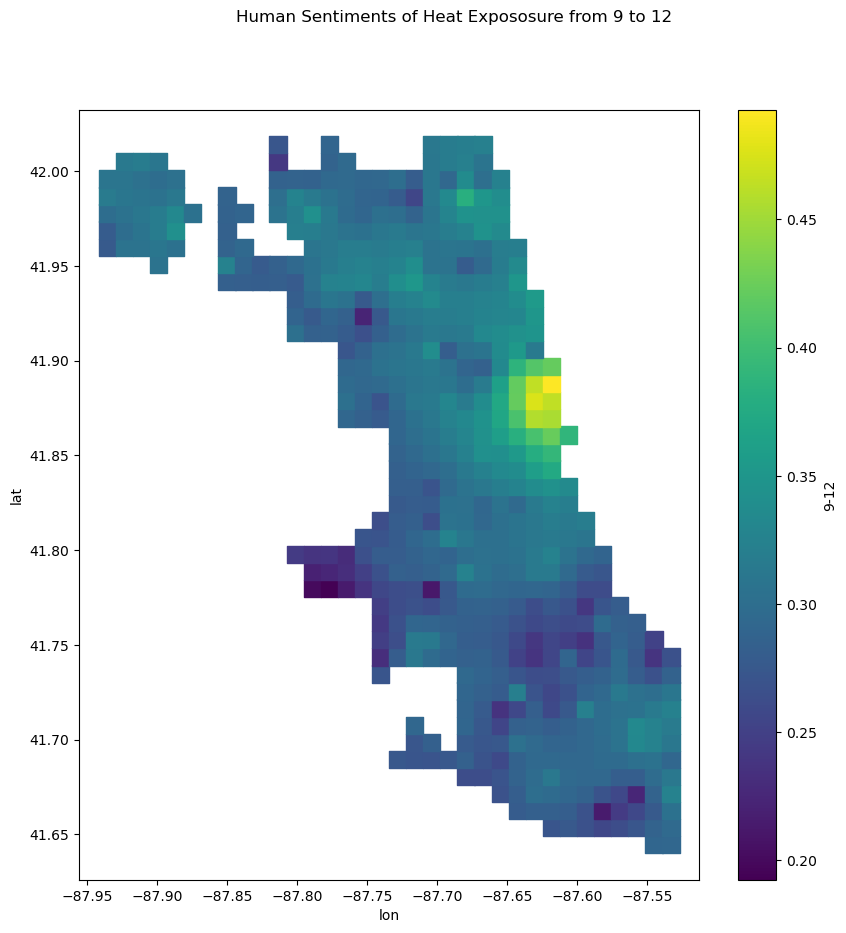

In [40]:
df.plot.scatter(title='Human Sentiments of Heat Expososure from 9 to 12', x='lon', y='lat', c='9-12', figsize = [10,10], subplots=True, marker="s", s = 155, colormap='viridis')

Visualize result for 12-15.

array([<Axes: xlabel='lon', ylabel='lat'>], dtype=object)

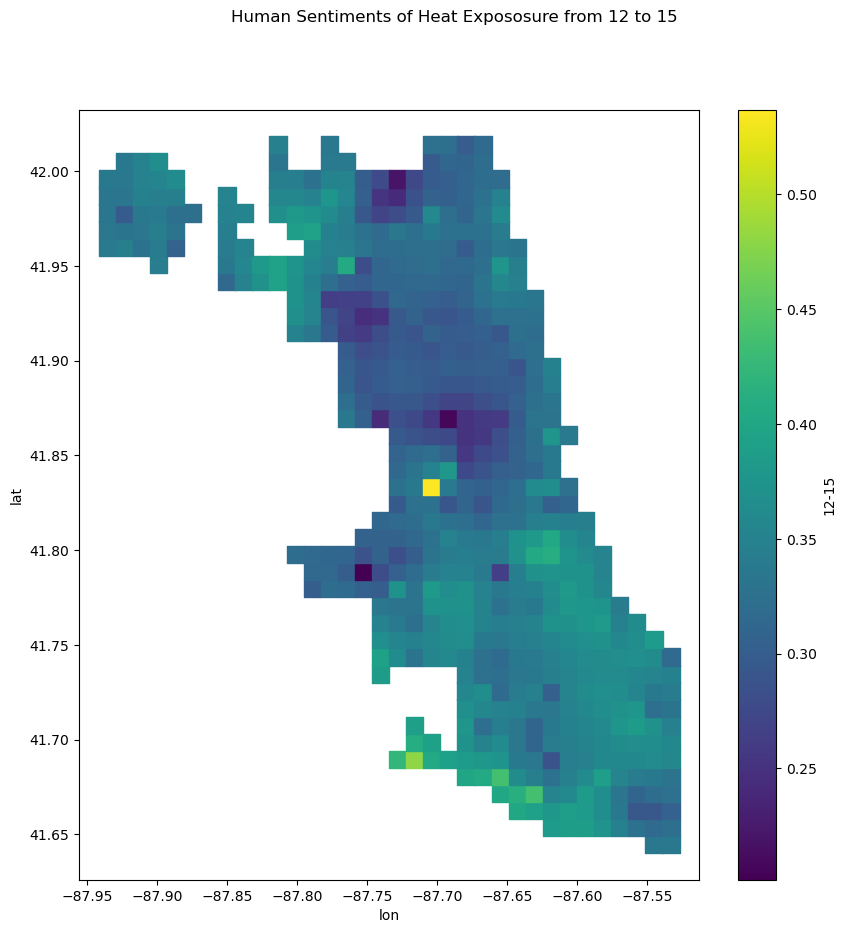

In [41]:
df.plot.scatter(title='Human Sentiments of Heat Expososure from 12 to 15', x='lon', y='lat', c='12-15', figsize = [10,10], subplots=True, marker="s", s = 155, colormap='viridis')

Visualize result for 15-18.

array([<Axes: xlabel='lon', ylabel='lat'>], dtype=object)

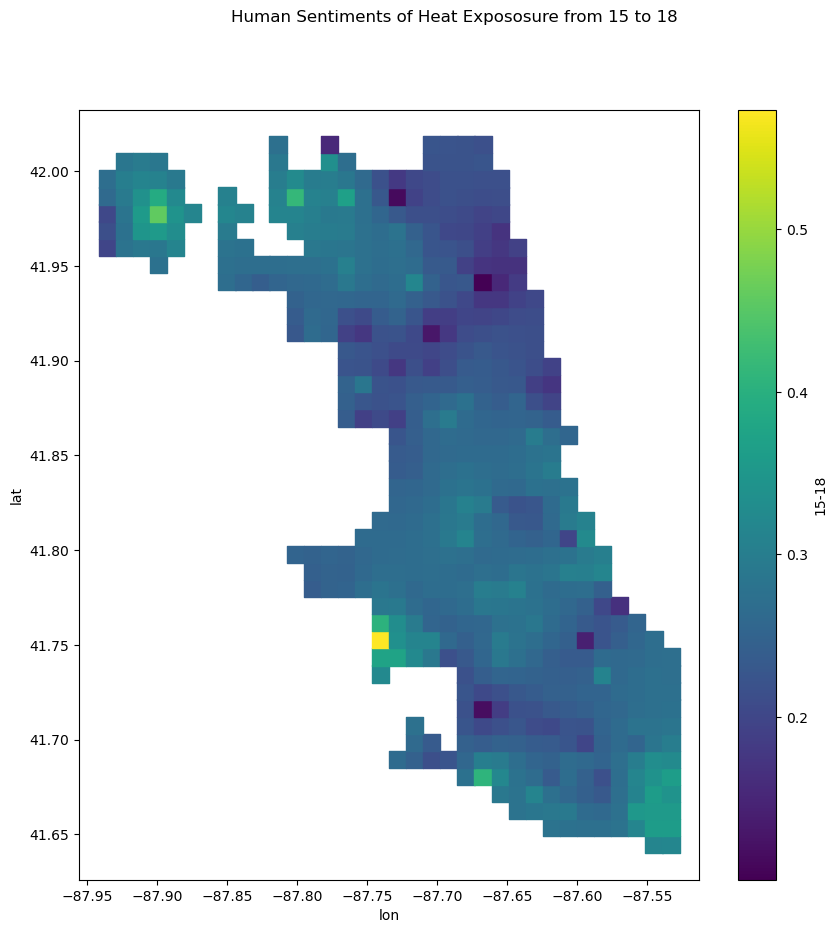

In [42]:
df.plot.scatter(title='Human Sentiments of Heat Expososure from 15 to 18', x='lon', y='lat', c='15-18', figsize = [10,10], subplots=True, marker="s", s = 155, colormap='viridis')